In [8]:
!pip install explainerdashboard


DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [33]:

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import PowerTransformer,StandardScaler
from sklearn.feature_selection import SelectKBest,f_regression,f_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from explainerdashboard import RegressionExplainer,ExplainerDashboard
import dtale

In [34]:
data=pd.read_csv('kc_house_data.csv')
dtale.show(data,ignore_duplicates=True)


In [26]:
def scale(data,columns):
    scaler=StandardScaler().set_output(transform='pandas')
    standardized_data=scaler.fit_transform(data)

    standardized_data.columns=columns
    return standardized_data

In [27]:
def transform(data,columns):
    transformer=PowerTransformer(method='yeo-johnson').set_output(transform='pandas')
    transformed_data=transformer.fit_transform(data)
    #transformed_data=pd.DataFrame(transformed_data)
    transformed_data.columns=columns
    return transformed_data


Data preprocessing


In [20]:
data_prep=data.drop(['id','date','lat','long','zipcode'],axis=1)

In [21]:
data_prep.drop_duplicates(inplace=True)


In [42]:
living=pd.DataFrame()
living['sqft_living']=data_prep['sqft_living']
living['bin']=pd.qcut(data_prep['sqft_living'],q=10)
living['bin'].unique()


[(1090.0, 1320.0], (2400.0, 2730.0], (289.999, 1090.0], (1910.0, 2130.0], (1520.0, 1710.0], (3254.0, 13540.0], (1710.0, 1910.0], (1320.0, 1520.0], (2730.0, 3254.0], (2130.0, 2400.0]]
Categories (10, interval[float64, right]): [(289.999, 1090.0] < (1090.0, 1320.0] < (1320.0, 1520.0] < (1520.0, 1710.0] ... (2130.0, 2400.0] < (2400.0, 2730.0] < (2730.0, 3254.0] < (3254.0, 13540.0]]

In [44]:
data_prep.isnull().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [80]:
data_prep.describe().round(2)


price  bedrooms  bathrooms  sqft_living    sqft_lot    floors  \
count    21607.00  21607.00   21607.00     21607.00    21607.00  21607.00   
mean    540106.71      3.37       2.11      2079.95    15110.19      1.49   
std     367171.02      0.93       0.77       918.53    41425.79      0.54   
min      75000.00      0.00       0.00       290.00      520.00      1.00   
25%     321725.00      3.00       1.75      1428.50     5040.00      1.00   
50%     450000.00      3.00       2.25      1910.00     7620.00      1.50   
75%     645000.00      4.00       2.50      2550.00    10692.00      2.00   
max    7700000.00     33.00       8.00     13540.00  1651359.00      3.50   

       waterfront      view  condition     grade  sqft_above  sqft_basement  \
count    21607.00  21607.00   21607.00  21607.00    21607.00       21607.00   
mean         0.01      0.23       3.41      7.66     1788.40         291.56   
std          0.09      0.77       0.65      1.18      828.16         442.62   
min          0.00      0.00       1.00      1.00      290.00           0.00   
25%          0.00      0.00       3.00      7.00     1190.00           0.00   
50%          0.00      0.00       3.00      7.00     1560.00           0.00   
75%          0.00      0.00       4.00      8.00     2210.00         560.00   
max          1.00      4.00       5.00     13.00     9410.00        4820.00   

       yr_built  yr_renovated  sqft_living15  sqft_lot15  
count  21607.00      21607.00       21607.00    21607.00  
mean    1971.00         84.33        1986.59    12770.57  
std       29.37        401.53         685.44    27307.55  
min     1900.00          0.00         399.00      651.00  
25%     1951.00          0.00        1490.00     5100.00  
50%     1975.00          0.00        1840.00     7620.00  
75%     1997.00          0.00        2360.00    10083.50  
max     2015.00       2015.00        6210.00   871200.00

In [46]:
bedrooms=data_prep['bedrooms'].drop_duplicates().sort_values()
info_price=pd.DataFrame(index=[ 'count','mean','std','min','25%','50%','75%','85%','95%','97%','99%','max'],columns=bedrooms)

for i in  bedrooms:
    b_data=data_prep[data_prep['bedrooms']==i]
    count,mean,std,min,p25,p50,p75,p85,p95,p97,p99,max=b_data['price'].count(),b_data['price'].mean(),b_data['price'].std(),b_data['price'].min(),b_data['price'].quantile(0.25),b_data['price'].quantile(0.50),b_data['price'].quantile(0.75),b_data['price'].quantile(0.85),b_data['price'].quantile(0.95),b_data['price'].quantile(0.97),b_data['price'].quantile(0.99),b_data['price'].max()
    info_price.loc[:,i]=[count,mean,std,min,p25,p50,p75,p85,p95,p97,p99,max]
info_price


bedrooms             0              1              2              3   \
count                13            199           2759           9821   
mean      409503.846154  317642.884422  401423.940558  466204.504531   
std       358682.627507  148864.955017  198069.417073  262504.818711   
min            139950.0        75000.0        78000.0        82000.0   
25%            235000.0       222000.0       269950.0       295450.0   
50%            288000.0       299000.0       374000.0       412500.0   
75%            355000.0       390000.0       490000.0       560000.0   
85%            523000.0       438720.0       558300.0       660000.0   
95%           1175260.0       577380.0       727749.9       888550.0   
97%           1223416.0       642010.0       810260.0      1015000.0   
99%           1271572.0       680660.0      1067940.0      1480000.0   
max           1295650.0      1247000.0      3278000.0      3800000.0   

bedrooms             4              5              6              7   \
count              6881           1600            272             38   
mean      635431.918035   786866.57875  825520.636029  951184.657895   
std       388621.317078  596294.829558  799238.819958  739953.558961   
min            100000.0       133000.0       175000.0       280000.0   
25%            376950.0       438000.0       435000.0       539250.0   
50%            549995.0       620000.0       650000.0       728580.0   
75%            765000.0       914166.0       896250.0       946500.0   
85%            900000.0      1195000.0      1136750.0      1559500.0   
95%           1350000.0      1803112.5      1880750.0      2515250.0   
97%           1600000.0      2239223.3      2327900.0      2837150.0   
99%           2274520.0      3100687.5      4128500.0      3083450.0   
max           4489000.0      7062500.0      7700000.0      3200000.0   

bedrooms              8              9              10        11        33  
count                 13              6              3         1         1  
mean      1105076.923077  893999.833333  819333.333333  520000.0  640000.0  
std        897495.725295  381533.900984  284677.595419       NaN       NaN  
min             340000.0       450000.0       650000.0  520000.0  640000.0  
25%             490000.0      624999.25       655000.0  520000.0  640000.0  
50%             700000.0       817000.0       660000.0  520000.0  640000.0  
75%            1650000.0      1193500.0       904000.0  520000.0  640000.0  
85%            2006000.0      1310000.0      1001600.0  520000.0  640000.0  
95%            2610000.0      1370000.0      1099200.0  520000.0  640000.0  
97%            2886000.0      1382000.0      1118720.0  520000.0  640000.0  
99%            3162000.0      1394000.0      1138240.0  520000.0  640000.0  
max            3300000.0      1400000.0      1148000.0  520000.0  640000.0

In [47]:
grades=data_prep['grade'].drop_duplicates().sort_values()
grade_price=pd.DataFrame(index=[ 'count','mean','std','min','25%','50%','75%','85%','95%','97%','99%','max'],columns=grades)

for i in  grades:
    b_data=data_prep[data_prep['grade']==i]
    count,mean,std,min,p25,p50,p75,p85,p95,p97,p99,max=b_data['price'].count(),b_data['price'].mean(),b_data['price'].std(),b_data['price'].min(),b_data['price'].quantile(0.25),b_data['price'].quantile(0.50),b_data['price'].quantile(0.75),b_data['price'].quantile(0.85),b_data['price'].quantile(0.95),b_data['price'].quantile(0.97),b_data['price'].quantile(0.99),b_data['price'].max()
    grade_price.loc[:,i]=[count,mean,std,min,p25,p50,p75,p85,p95,p97,p99,max]
grade_price

grade        1              3              4              5              6   \
count         1              3             29            242           2038   
mean   142000.0  205666.666667  214381.034483  248523.971074   301919.63739   
std         NaN  113517.986827   94306.167816  118100.279986  122970.280459   
min    142000.0        75000.0        80000.0        78000.0        82000.0   
25%    142000.0       168500.0       145000.0       175000.0       215037.5   
50%    142000.0       262000.0       205000.0       228700.0       275276.5   
75%    142000.0       271000.0       265000.0       295750.0       366837.5   
85%    142000.0       274600.0       329000.0       342550.0       418725.0   
95%    142000.0       278200.0       355000.0       487702.5       519075.0   
97%    142000.0       278920.0       367800.0       531785.0       570000.0   
99%    142000.0       279640.0       412600.0       691630.0       695375.0   
max    142000.0       280000.0       435000.0       795000.0      1200000.0   

grade             7              8              9               10  \
count           8981           6065           2612            1134   
mean   402590.262332    542879.7662  773875.394717  1071771.074074   
std    155876.922033  217514.379706  316084.112583   483545.090895   
min          90000.0       140000.0       230000.0        316000.0   
25%         285000.0       390000.0      572086.25        768087.5   
50%         375000.0       510000.0       721000.0        914327.0   
75%         485000.0       640000.0       880000.0       1250000.0   
85%         555000.0       729381.2      1001050.0       1506200.0   
95%         698000.0       915000.0      1388450.0       2075500.0   
97%         750000.0      1020000.0      1567010.0       2350250.0   
99%         875000.0      1298320.4      1899450.0       2873450.0   
max        2050000.0      3070000.0      2700000.0       3600000.0   

grade              11              12              13  
count             399              90              13  
mean   1496841.726817       2191222.0  3709615.384615  
std     705099.296865  1027818.627125  1859449.897974  
min          420000.0        835000.0       1780000.0  
25%         1036000.0       1500000.0       2415000.0  
50%         1284000.0       1817500.0       2983000.0  
75%         1700000.0       2668500.0       3800000.0  
85%         2200000.0       3151687.5       5833000.0  
95%         2950000.0       4495050.0       7211000.0  
97%         3200240.0       4814124.0       7406600.0  
99%         3423242.0       5305500.0       7602200.0  
max         7062500.0       5350000.0       7700000.0

In [48]:

view=data_prep['view'].drop_duplicates().sort_values()
view_price=pd.DataFrame(index=[ 'count','mean','std','min','25%','50%','75%','85%','95%','97%','99%','max'],columns=view)

for i in  view:
    b_data=data_prep[data_prep['view']==i]
    count,mean,std,min,p25,p50,p75,p85,p95,p97,p99,max=b_data['price'].count(),b_data['price'].mean(),b_data['price'].std(),b_data['price'].min(),b_data['price'].quantile(0.25),b_data['price'].quantile(0.50),b_data['price'].quantile(0.75),b_data['price'].quantile(0.85),b_data['price'].quantile(0.95),b_data['price'].quantile(0.97),b_data['price'].quantile(0.99),b_data['price'].max()
    view_price.loc[:,i]=[count,mean,std,min,p25,p50,p75,p85,p95,p97,p99,max]
view_price

view               0              1              2              3  \
count          19484            332            963            509   
mean   496574.126976  812280.837349   792400.88785  972794.282908   
std    287162.366361  510949.684596  510105.050867  613008.602062   
min          75000.0       217000.0       169317.0       154000.0   
25%         311000.0       498750.0       485000.0       560000.0   
50%         432500.0       690944.0       675000.0       805000.0   
75%         600000.0       921250.0       941250.0      1258000.0   
85%         720000.0      1178150.0      1159220.0      1484200.0   
95%         962680.0      1841500.0      1689800.0      2000000.0   
97%        1149510.0      2201750.0      1999133.0      2286480.0   
99%        1584190.0      2853500.0      2634218.0      2880000.0   
max        5570000.0      3650000.0      7062500.0      7700000.0   

view                4  
count             319  
mean   1463711.238245  
std     952209.550006  
min          252000.0  
25%          817500.0  
50%         1185000.0  
75%         1850000.0  
85%         2300000.0  
95%         3280200.0  
97%         3618814.0  
99%         5031096.0  
max         6885000.0

<Axes: xlabel='grade', ylabel='price'>

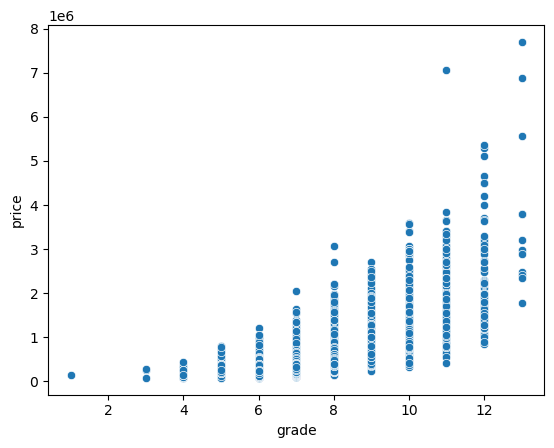

In [49]:
sns.scatterplot(data_prep,x='grade',y='price')

<Axes: xlabel='bedrooms', ylabel='price'>

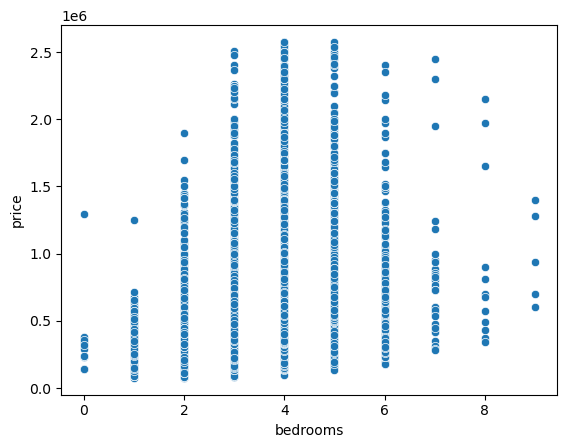

In [185]:
sns.scatterplot(data_prep,x='bedrooms',y='price')


<Axes: xlabel='sqft_living', ylabel='price'>

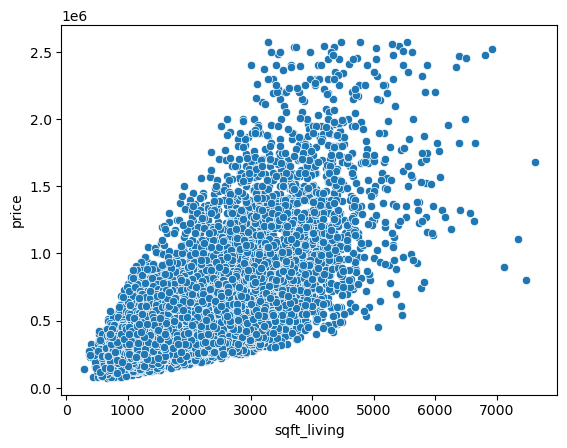

In [186]:
sns.scatterplot(data_prep,x='sqft_living',y='price')


<Axes: >

c:\Users\KenilChandani\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\KenilChandani\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


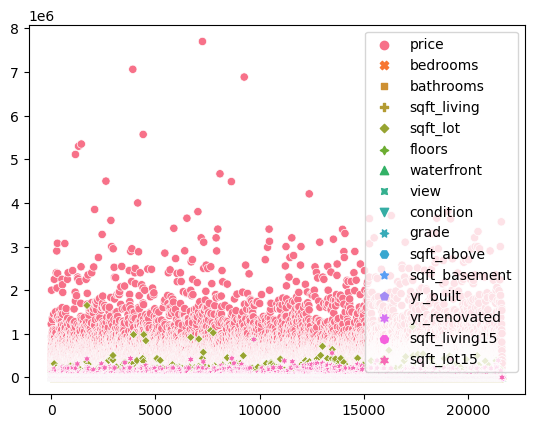

In [50]:
sns.scatterplot(data_prep)

<Axes: xlabel='bedrooms', ylabel='price'>

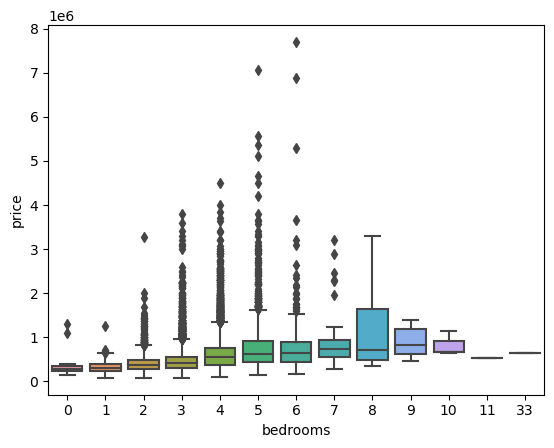

In [51]:
sns.boxplot(data,x='bedrooms',y='price')

In [22]:
def z_score(df,variable):

    lower=df[variable].mean() - 3*df[variable].std()
    upper=df[variable].mean() + 3*df[variable].std()
    #print(f" Variable={variable},Lower Limit:{lower},Upper Limit:{upper}")
    median=np.median(df[variable])

    df[variable]=np.where((df[variable]>=lower) & (df[variable]<= upper),df[variable],median)
    return df  

def outlier(df,variable,lq,uq,weight):
    iqr=df[variable].quantile(uq)-df[variable].quantile(lq)
    lower=df[variable].quantile(lq)-(iqr*weight)
    upper=df[variable].quantile(uq)+(iqr*weight)

    median=np.median(df[variable])
    df=df[(df[variable]>lower)&(df[variable]<upper)] #Removing Outliers
    #df[variable].clip(lower=lower,upper=upper,inplace=True)  #Flooring & Capping
    #df.loc[(df[variable]>lower)&(df[variable]<upper),df[variable]]=np.nan
    #df.fillna(df[variable].interpolate(method='linear'),inplace=True)
    
    #df[variable]=np.where((df[variable]>=lower) & (df[variable]<= upper),df[variable],median) #Replacing outlier
    #print(f"Upper Limit:{upper}, Max={df[variable].max()}")
    
    #df[variable]=df[variable].mask((df[variable]>lower) & (df[variable]<upper),median)
    
    return df
for col in ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement','sqft_living15','sqft_lot15']:
    data_prep=outlier(data_prep,col,0.05,0.95,1.5)
data_prep.describe().round(2)


price  bedrooms  bathrooms  sqft_living   sqft_lot    floors  \
count    20904.00  20904.00   20904.00     20904.00   20904.00  20904.00   
mean    525461.24      3.36       2.10      2045.03    9970.20      1.49   
std     313026.96      0.90       0.75       859.78   10453.98      0.54   
min      75000.00      0.00       0.00       290.00     520.00      1.00   
25%     320000.00      3.00       1.50      1410.00    5000.00      1.00   
50%     449000.00      3.00       2.25      1900.00    7500.00      1.50   
75%     635000.00      4.00       2.50      2510.00   10200.00      2.00   
max    2575000.00      9.00       6.75      7620.00  104108.00      3.00   

       waterfront      view  condition     grade  sqft_above  sqft_basement  \
count    20904.00  20904.00   20904.00  20904.00    20904.00       20904.00   
mean         0.01      0.22       3.41      7.63     1757.18         287.84   
std          0.08      0.74       0.65      1.14      782.96         431.65   
min          0.00      0.00       1.00      1.00      290.00           0.00   
25%          0.00      0.00       3.00      7.00     1180.00           0.00   
50%          0.00      0.00       3.00      7.00     1540.00           0.00   
75%          0.00      0.00       4.00      8.00     2170.00         560.00   
max          1.00      4.00       5.00     13.00     6640.00        2850.00   

       yr_built  yr_renovated  sqft_living15  sqft_lot15  
count  20904.00      20904.00       20904.00    20904.00  
mean    1970.68         83.07        1967.54     9214.23  
std       29.46        398.65         670.38     8286.64  
min     1900.00          0.00         460.00      651.00  
25%     1951.00          0.00        1480.00     5040.00  
50%     1974.00          0.00        1820.00     7515.00  
75%     1996.00          0.00        2340.00     9800.00  
max     2015.00       2015.00        5790.00    71002.00

<Axes: xlabel='bedrooms', ylabel='price'>

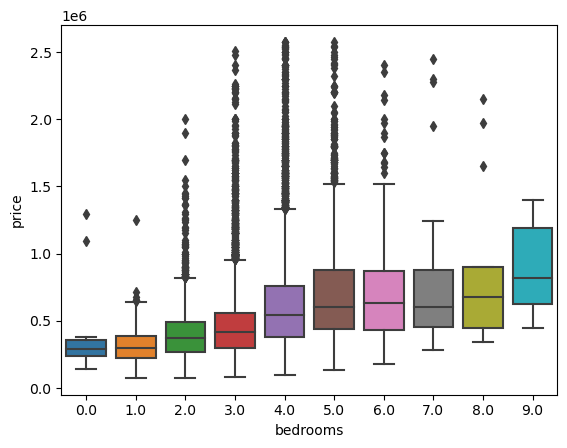

In [147]:
sns.boxplot(data_prep,x='bedrooms',y='price')

<Axes: xlabel='price', ylabel='Count'>

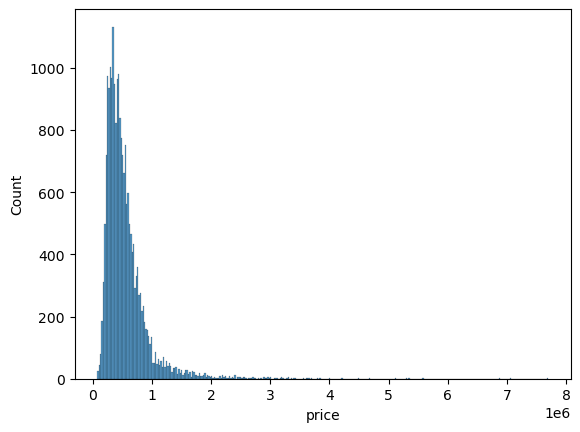

In [54]:
sns.histplot(data,x='price')

In [23]:
scaler=StandardScaler().set_output(transform='pandas')
standardized_data=scaler.fit_transform(data_prep)

standardized_data.columns=[data_prep.columns]
standardized_data.head()


price  bedrooms bathrooms sqft_living  sqft_lot    floors waterfront  \
0 -0.969784 -0.404835 -1.465395   -1.006127 -0.413269 -0.909492  -0.077248   
1  0.040057 -0.404835  0.203939    0.610605 -0.260979  0.943712  -0.077248   
2 -1.103641 -1.517027 -1.465395   -1.483005  0.002850 -0.909492  -0.077248   
3  0.250907  0.707357  1.205540   -0.098896 -0.475448 -0.909492  -0.077248   
4 -0.049394 -0.404835 -0.129928   -0.424569 -0.180816 -0.909492  -0.077248   

       view condition     grade sqft_above sqft_basement  yr_built  \
0 -0.297259 -0.631716 -0.551087  -0.737198     -0.666867 -0.532326   
1 -0.297259 -0.631716 -0.551087   0.527266      0.259837 -0.668088   
2 -0.297259 -0.631716 -1.429264  -1.260865     -0.666867 -1.279014   
3 -0.297259  2.439305 -0.551087  -0.903239      1.441385 -0.192923   
4 -0.297259 -0.631716  0.327090  -0.098580     -0.666867  0.553765   

  yr_renovated sqft_living15 sqft_lot15  
0    -0.208383     -0.936126  -0.430128  
1     4.786069     -0.414020  -0.190097  
2    -0.208383      1.122465  -0.139050  
3    -0.208383     -0.906292  -0.508569  
4    -0.208383     -0.249929  -0.206510

In [24]:
transformer=PowerTransformer(method='yeo-johnson').set_output(transform='pandas')
transformed_data=transformer.fit_transform(standardized_data)
#transformed_data=pd.DataFrame(transformed_data)
transformed_data.columns=data_prep.columns
transformed_data.describe().round(2)


price  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
count  20904.00  20904.00   20904.00     20904.00  20904.00  20904.00   
mean      -0.00      0.00      -0.00        -0.00     -0.00     -0.00   
std        1.00      1.00       1.00         1.00      1.00      1.00   
min       -2.82     -4.51      -3.08        -3.05     -2.46     -0.96   
25%       -0.75     -0.36      -0.79        -0.74     -0.66     -0.96   
50%        0.01     -0.36       0.25         0.01      0.04      0.25   
75%        0.73      0.74       0.57         0.71      0.57      1.02   
max        2.79      5.01       5.35         3.59      2.55      2.05   

       waterfront      view  condition     grade  sqft_above  sqft_basement  \
count    20904.00  20904.00   20904.00  20904.00    20904.00       20904.00   
mean        -0.00     -0.00      -0.00      0.00        0.00           0.00   
std          1.00      1.00       1.00      1.00        1.00           1.00   
min         -0.08     -0.32      -8.44     -9.31       -3.22          -0.77   
25%         -0.08     -0.32      -0.59     -0.50       -0.77          -0.77   
50%         -0.08     -0.32      -0.59     -0.50       -0.06          -0.77   
75%         -0.08     -0.32       1.04      0.44        0.77           1.16   
max         12.95      3.12       1.88      3.46        3.00           1.98   

       yr_built  yr_renovated  sqft_living15  sqft_lot15  
count  20904.00      20904.00       20904.00    20904.00  
mean      -0.00         -0.00           0.00        0.00  
std        1.00          1.00           1.00        1.00  
min       -2.03         -0.21          -3.67       -2.62  
25%       -0.75         -0.21          -0.73       -0.66  
50%       -0.01         -0.21          -0.03        0.09  
75%        0.86         -0.21           0.74        0.58  
max        1.73          4.80           3.18        2.63

<Axes: xlabel='price', ylabel='Count'>

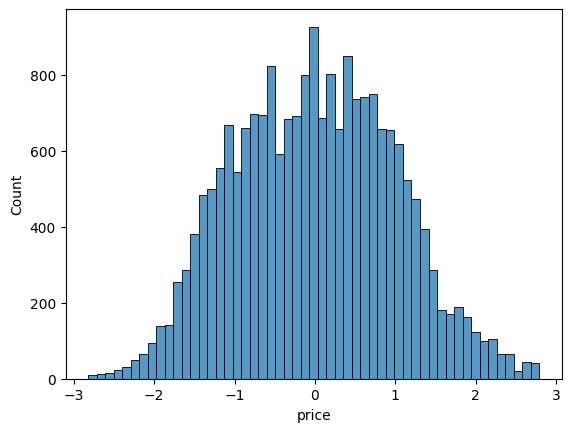

In [25]:
sns.histplot(transformed_data['price'])


In [26]:
X=transformed_data.drop('price',axis=1)
y=transformed_data['price']


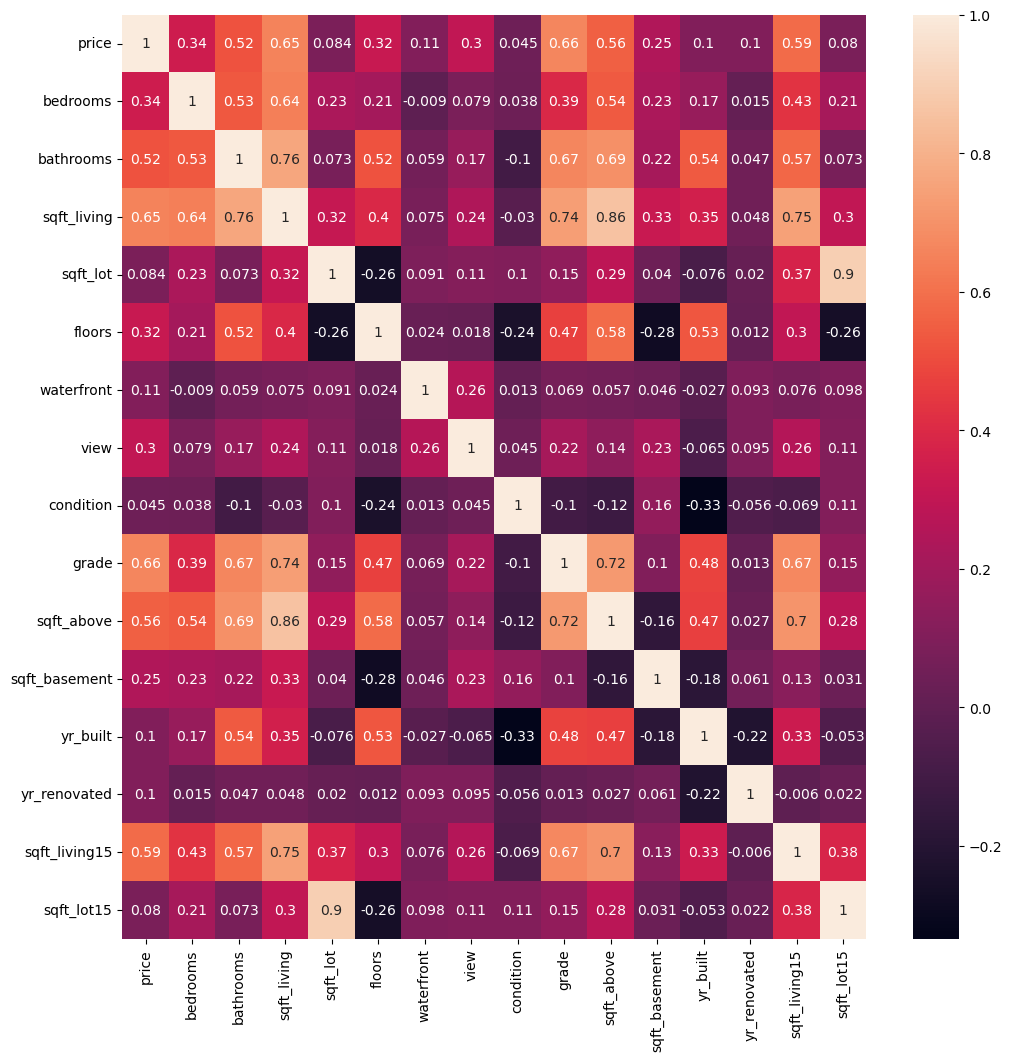

In [127]:
c=transformed_data.corr()
plt.figure(figsize=(12,12))
sns.heatmap(c,annot=True)
plt.show()

bedrooms  bathrooms  sqft_living  sqft_lot    floors  waterfront      view  \
0 -0.355609  -1.529602    -1.154714 -0.456320 -0.961598   -0.077248 -0.321113   
1 -0.355609   0.247728     0.768715 -0.025569  1.021036   -0.077248 -0.321113   
2 -1.632037  -1.529602    -1.970293  0.537130 -0.961598   -0.077248 -0.321113   
3  0.742188   1.189630     0.094605 -0.656435 -0.961598   -0.077248 -0.321113   
4 -0.355609  -0.086345    -0.304220  0.168953 -0.961598   -0.077248 -0.321113   

   condition     grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0  -0.590420 -0.496067   -0.769982      -0.774517 -0.629194     -0.208389   
1  -0.590420 -0.496067    0.774035       0.903753 -0.746515      4.798707   
2  -0.590420 -1.645259   -1.780377      -0.774517 -1.237632     -0.208389   
3   1.883695 -0.496067   -1.067500       1.476128 -0.318416     -0.208389   
4  -0.590420  0.441416    0.167183      -0.774517  0.486980     -0.208389   

   sqft_living15  sqft_lot15  
0      -1.064434   -0.451502  
1      -0.278830    0.119715  
2       1.160689    0.221851  
3      -1.015371   -0.672149  
4      -0.065504    0.085476

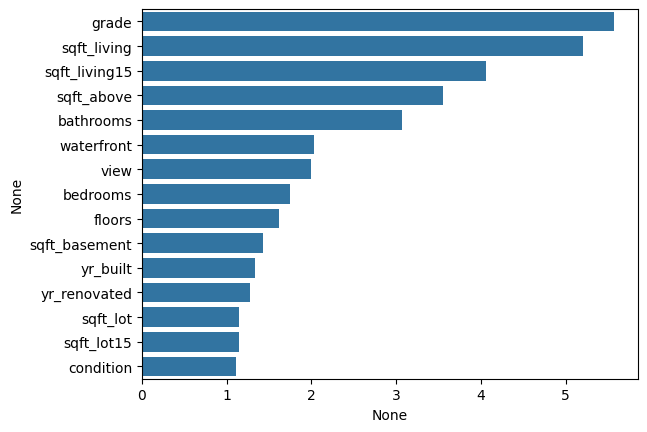

In [27]:
skb=SelectKBest(score_func=f_classif,k=15)
data_selected=skb.fit_transform(X,y)
data_selected=pd.DataFrame(data_selected)
data_selected.columns=skb.get_feature_names_out()
score=pd.Series(skb.scores_)
score.index=X.columns
score.sort_values(ascending=False,inplace=True)
sns.barplot(x=score,y=score.index)
data_selected.head()


In [28]:
X_train,X_test,y_train,y_test=train_test_split(data_selected,y,train_size=0.7)

In [29]:
reg=LinearRegression()
reg.fit(X_train,y_train)
pred=reg.predict(X_test)
res=pd.DataFrame({
    'Original':y_test,
    'Predicted':pred,
    'error':pred-y_test
})

r2_score(y_test,pred)

0.6258357400997995

In [30]:
exp=RegressionExplainer(reg,X_test,y_test)

Generating self.shap_explainer = shap.LinearExplainer(modelX)...


In [32]:
ExplainerDashboard(exp).run()

Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
For this type of model and model_output interactions don't work, so setting shap_interaction=False...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...
Calculating predictions...
Calculating residuals...
Calculating absolute residuals...
Calculating dependencies...
Calculating importances...
Reminder: you can store the explainer (including calculated dependencies) with explainer.dump('explainer.joblib') and reload with e.g. ClassifierExplainer.from_file('explainer.joblib')
Registering callbacks...
Starting ExplainerDashboard on http://10.224.0.29:8050


In [13]:
data1=pd.read_csv('kc_house_data.csv')
X1=data1.drop(columns=['id','price','date'])
y1=data1['price']

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X1,y1,train_size=0.7)

In [15]:
rfr=RandomForestRegressor(n_estimators=200,n_jobs=4)
rfr.fit(X_train,y_train)
pred=rfr.predict(X_test)


In [16]:
r2_score(y_test, pred)


0.8855242822901378

In [2]:
res=pd.DataFrame({
    'Original':X_test,
    'Predicted':pred,
    'error':pred-y_test
})

res

NameError: name 'pd' is not defined

In [ ]:
sns.regplot(x=pred,y=y_test)

In [216]:
y_pred=pd.DataFrame(pred)

0
0     1.559036e+06
1     5.407349e+05
2     6.072447e+05
3     4.958894e+05
4     5.503067e+05
...            ...
6479  2.045257e+05
6480  9.511596e+05
6481  7.226270e+05
6482  8.992488e+05
6483  7.456818e+05

[6484 rows x 1 columns]

In [236]:
temp=pd.DataFrame(X_test)
temp['prediction']=pred
temp

bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  \
7269          4       3.25         4250     12281     2.0           0     4   
7003          4       2.00         2090      4000     1.0           0     0   
16297         4       2.25         2330      7020     1.0           0     0   
9102          4       2.50         2540      6365     2.0           0     0   
307           4       2.25         2180      7297     2.0           0     0   
...         ...        ...          ...       ...     ...         ...   ...   
21585         3       2.50         1870      5000     2.0           0     0   
2366          6       3.00         4250      4400     2.5           0     0   
16046         3       2.00         2610      6000     1.0           0     0   
3499          4       3.25         1860      4356     2.0           0     0   
11025         4       3.25         2590      3889     3.0           0     0   

       condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
7269           3     12        3020           1230      1996             0   
7003           3      7        1480            610      1951             0   
16297          4      8        1450            880      1973             0   
9102           3      8        1870            670      2000             0   
307            3      8        2180              0      1984             0   
...          ...    ...         ...            ...       ...           ...   
21585          3      7        1870              0      2009             0   
2366           4      7        3020           1230      1902             0   
16046          5      7        1310           1300      1941             0   
3499           3      9        1860              0      1917          2005   
11025          3      9        2590              0      2013             0   

       zipcode      lat     long  sqft_living15  sqft_lot15    prediction  
7269     98006  47.5507 -122.113           4940       12941  1.559036e+06  
7003     98107  47.6751 -122.379           1510        5000  5.407349e+05  
16297    98006  47.5620 -122.139           2330        8500  6.072447e+05  
9102     98055  47.4608 -122.215           2290        5942  4.958894e+05  
307      98074  47.6459 -122.058           2250        9781  5.503067e+05  
...        ...      ...      ...            ...         ...           ...  
21585    98042  47.3339 -122.055           2170        5399  2.045257e+05  
2366     98118  47.5584 -122.283           1520        4950  9.511596e+05  
16046    98115  47.6750 -122.289           2330        4800  7.226270e+05  
3499     98103  47.6785 -122.351           1860        4356  8.992488e+05  
11025    98007  47.6259 -122.142           2590        4062  7.456818e+05  

[6484 rows x 19 columns]